In [2]:
from datetime import datetime, timedelta
from elasticsearch import Elasticsearch
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
# es 검색 테스트
# es = Elasticsearch('http://localhost:9199')
# body = {
#     "query": {
#         "bool": {
#             "must": [
#                 {"multi_match": {
#                     "type": "phrase_prefix",
#                     "query": "경찰",
#                     "fields": ["headLine", "content", "subHeadLine"]
#                 }},
#                 {"range":{
#                     "date": {
#                         "gte": "20221109",
#                         "lte":"20221112"
#                     }
#                 }}
#             ]
#         }
#     }
# }
# res = es.count(index='kpf_bigkindslab_2022', body=body)
# print(res['count'])

In [3]:
# 기간안의 모든 날짜 리스트 생성 def
def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [(start + timedelta(days=i)).strftime("%Y%m%d") for i in range((end-start).days+1)]
    return dates

In [15]:
stDt = '20180812'
edDt = '20180819'
keyword_list = ['이태원', '할로윈', '외국인'] # , ...

dates = date_range(stDt, edDt)

# es 검색 => 일별 기사건수 받아오기, 기사 없을 경우 0
# for문 사용해야함 수정필요, 임시작성
# es = Elasticsearch()
# body = {
#     "query": {
#         "bool": {
#             "must": [
#                 {"multi_match": {
#                     "type": "phrase_prefix",
#                     "query": keyword_list[0],
#                     "fields": ["headLine", "content", "subHeadLine"]
#                 }},
#                 {"range":{
#                     "date": {
#                         "gte": stDt,
#                         "lte":edDt
#                     }
#                 }}
#             ]
#         }
#     }
# }
# es.count(index='kpf_bigkindslab_*', body=body)

result = dict() # java 단으로 넘길 데이터
values = dict() # 통계 계산 사용 데이터
result['dates'] = dates
keyword_cnt = dict()

# 실제로는 es 검색 결과 기사건수 받아오는 것으로
for keyword in keyword_list: # 샘플데이터
    if keyword == '이태원':
        keyword_cnt[keyword] = [13,15,16,17,16,17,17,20]
        values[keyword] = [13,15,16,17,16,17,17,20]
    elif keyword == '할로윈':
        keyword_cnt[keyword] = [20,15,17,28,40,12,10,20]
        values[keyword] = [20,15,17,28,40,12,10,20]
    elif keyword == '외국인':
        keyword_cnt[keyword] = [65,21,61,21,12,32,15,35]
        values[keyword] = [65,21,61,21,12,32,15,35]

result['keywordCnt'] = keyword_cnt
print(result)

{'dates': ['20180812', '20180813', '20180814', '20180815', '20180816', '20180817', '20180818', '20180819'], 'keywordCnt': {'이태원': [13, 15, 16, 17, 16, 17, 17, 20], '할로윈': [20, 15, 17, 28, 40, 12, 10, 20], '외국인': [65, 21, 61, 21, 12, 32, 15, 35]}}
2018


In [5]:
values_df = pd.DataFrame(values,index=result['dates'])
values_df

,이태원,할로윈,외국인
20180812,13,20,65
20180813,15,15,21
20180814,16,17,61
20180815,17,28,21
20180816,16,40,12
20180817,17,12,32
20180818,17,10,15
20180819,20,20,35


In [6]:
# 기초통계
def basic_statics(df):
    basic_res = []
    for key in keyword_list:
        val_dict = dict()
        val_dict['key'] = key
        val_dict['count'] = df.count()[key]
        val_dict['sum'] = df.sum()[key]
        val_dict['mean'] = df.mean()[key]
        val_dict['min'] = df.min()[key]
        val_dict['median'] = df.median()[key]
        val_dict['max'] = df.max()[key]
        val_dict['var'] = df.var()[key]
        val_dict['std'] = df.std()[key]
        basic_res.append(val_dict)
    return basic_res

basic_res = basic_statics(values_df)
print(basic_res) # java 단으로 넘길 기초통계 결과

[{'key': '이태원', 'count': 8, 'sum': 131, 'mean': 16.375, 'min': 13, 'median': 16.5, 'max': 20, 'var': 3.9821428571428568, 'std': 1.9955307206712847}, {'key': '할로윈', 'count': 8, 'sum': 162, 'mean': 20.25, 'min': 10, 'median': 18.5, 'max': 40, 'var': 94.5, 'std': 9.72111104761179}, {'key': '외국인', 'count': 8, 'sum': 262, 'mean': 32.75, 'min': 12, 'median': 26.5, 'max': 65, 'var': 409.35714285714283, 'std': 20.2325762782979}]


In [7]:
# 상관관계
def cor_statics(df):
    cor_res = []
    n = 0
    for res in basic_res:
        n += res['sum']
    # print(df.corr(method='pearson'))
    # print(df.corr(method='pearson')['이태원'][1])
    for key1 in keyword_list:
        for key2 in keyword_list:
            pear_cor = stats.pearsonr(df[key1], df[key2])
            # print(key1, key2)
            # print(pear_cor[0]) # pearson 상관계수
            # print(pear_cor[1]) # 유의확률
            cor_dict = dict()
            cor_dict['key1'] = key1
            cor_dict['key2'] = key2
            cor_dict['Pearson'] = pear_cor[0]
            cor_dict['pval'] = pear_cor[1]
            cor_dict['N'] = n
            cor_res.append(cor_dict)

    return cor_res
cor_res = cor_statics(values_df)
print(cor_res)

[{'key1': '이태원', 'key2': '이태원', 'Pearson': 1.0, 'pval': 0.0, 'N': 555}, {'key1': '이태원', 'key2': '할로윈', 'Pearson': -0.04234435114195801, 'pval': 0.9206991971671423, 'N': 555}, {'key1': '이태원', 'key2': '외국인', 'Pearson': -0.3759423867424321, 'pval': 0.3587081722972465, 'N': 555}, {'key1': '할로윈', 'key2': '이태원', 'Pearson': -0.04234435114195801, 'pval': 0.9206991971671423, 'N': 555}, {'key1': '할로윈', 'key2': '할로윈', 'Pearson': 1.0, 'pval': 0.0, 'N': 555}, {'key1': '할로윈', 'key2': '외국인', 'Pearson': -0.2553055163808246, 'pval': 0.5416967086866459, 'N': 555}, {'key1': '외국인', 'key2': '이태원', 'Pearson': -0.3759423867424321, 'pval': 0.3587081722972465, 'N': 555}, {'key1': '외국인', 'key2': '할로윈', 'Pearson': -0.2553055163808246, 'pval': 0.5416967086866459, 'N': 555}, {'key1': '외국인', 'key2': '외국인', 'Pearson': 1.0, 'pval': 0.0, 'N': 555}]


In [10]:
# 산점도
def scatter(df, key1, key2):
    keyCnt = dict()
    lineRes = dict()
    z = np.polyfit(values_df[key1], values_df[key2], 1)
    f = np.poly1d(z)
    keyCnt['x'] = values_df[key1].to_list()
    keyCnt['y'] = values_df[key2].to_list()
    print(keyCnt)
    slope = z[0]
    intercept = z[1]
    lineRes['slope'] = slope
    lineRes['intercept'] = intercept
    print(lineRes)
scatter(values_df, '이태원', '할로윈')

{'x': [13, 15, 16, 17, 16, 17, 17, 20], 'y': [20, 15, 17, 28, 40, 12, 10, 20]}
{'slope': -0.206278026905831, 'intercept': 23.627802690582982}


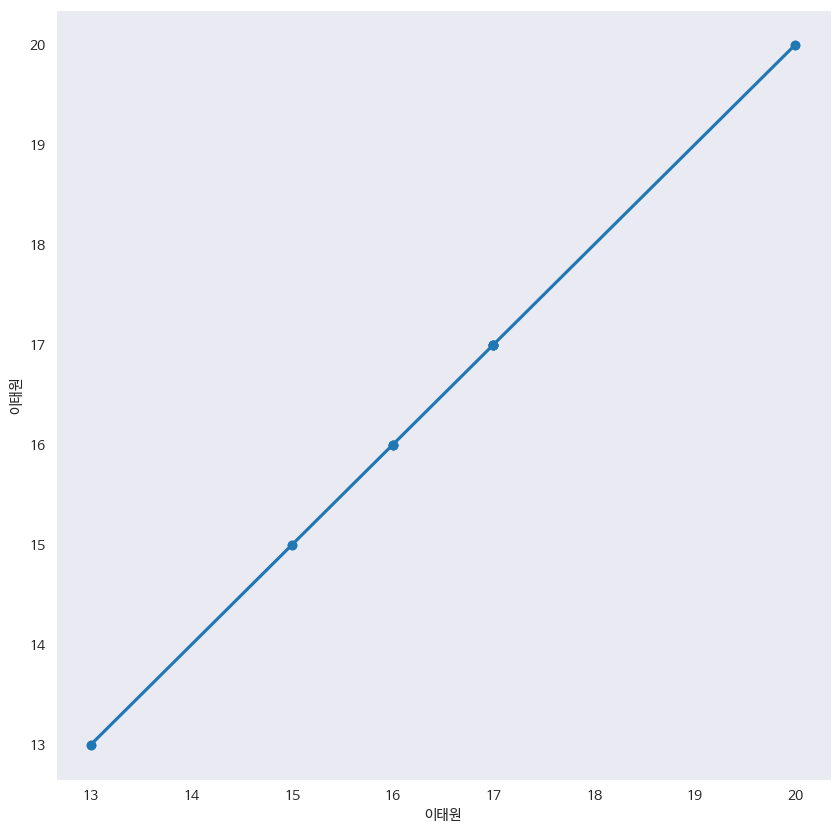

1.0000000000000004 -2.009718347115232e-14
0.9999999999999803


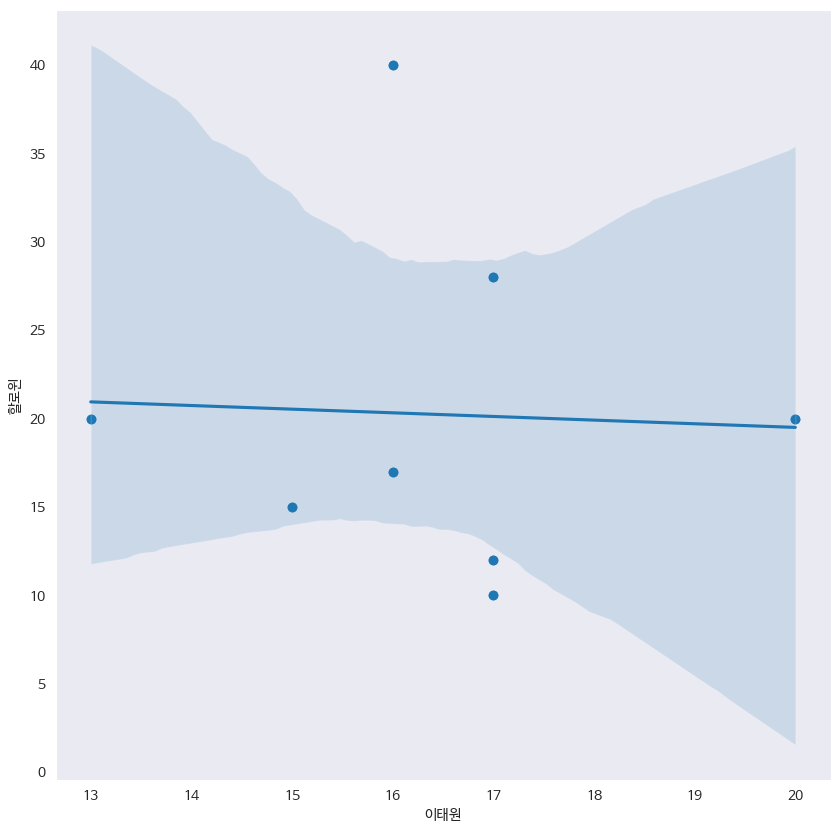

-0.206278026905831 23.627802690582982
23.42152466367715


D:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


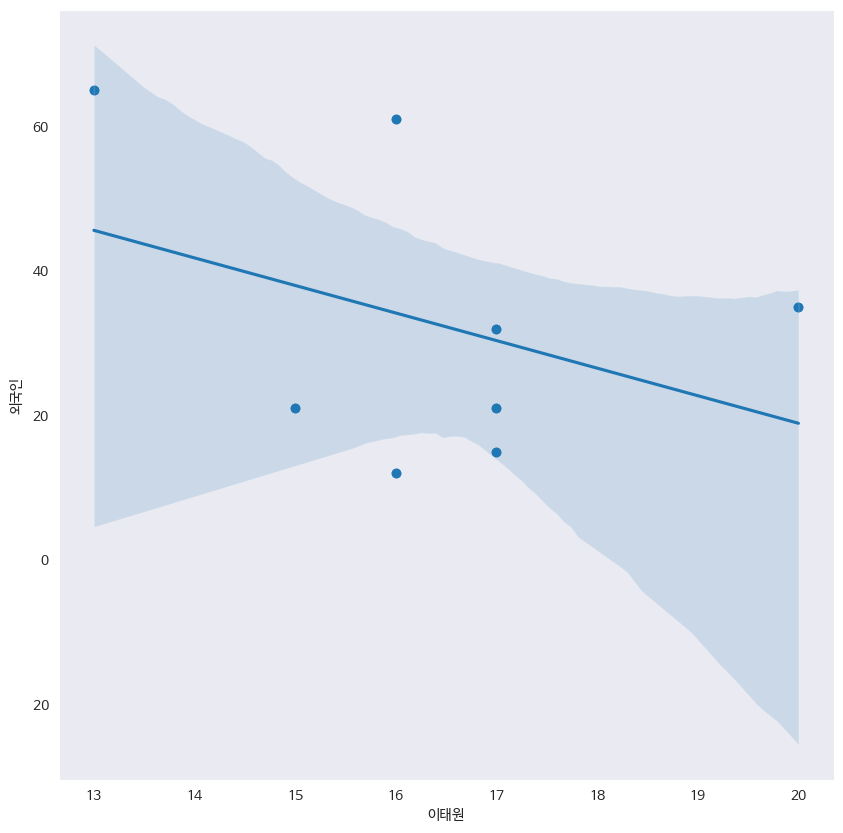

-3.8116591928251053 95.1659192825111
91.354260089686


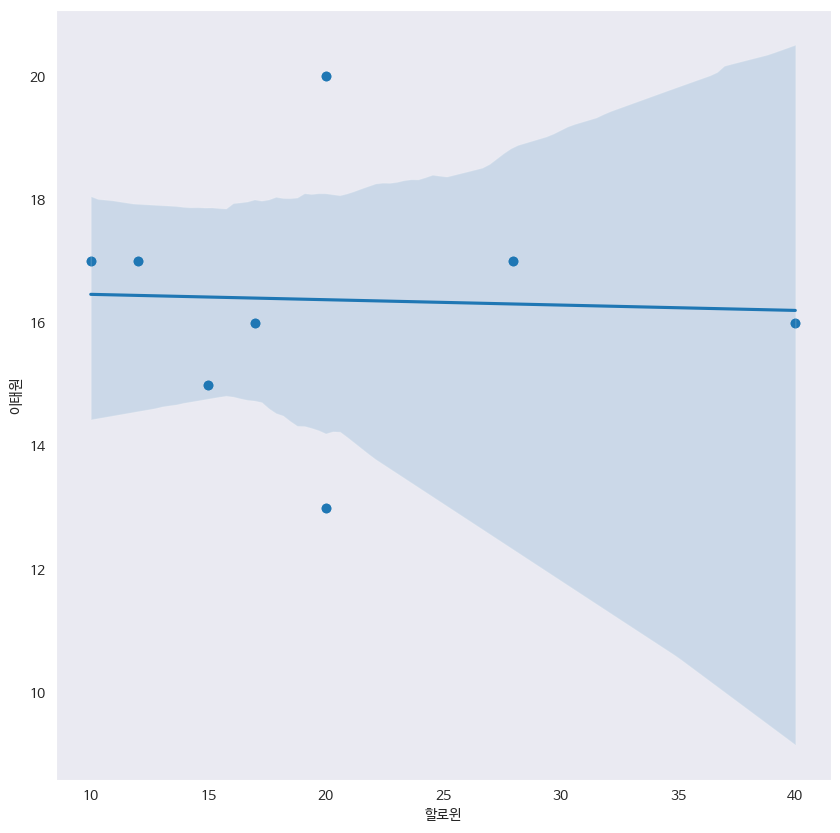

-0.008692365835223106 16.551020408163264
16.54232804232804


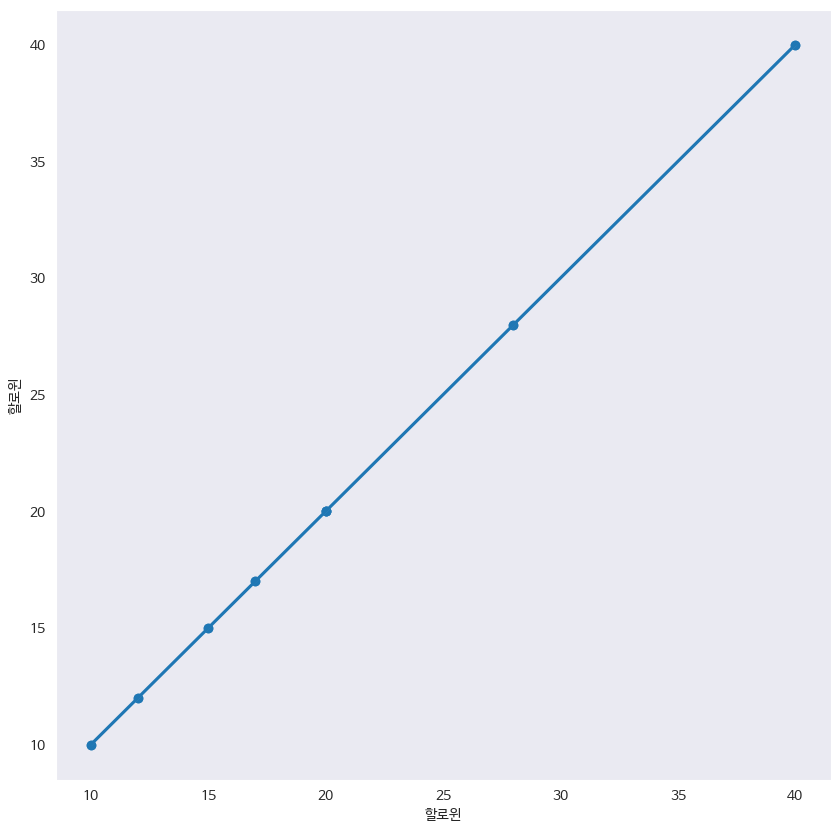

1.0 2.51214793389404e-15
1.0000000000000024


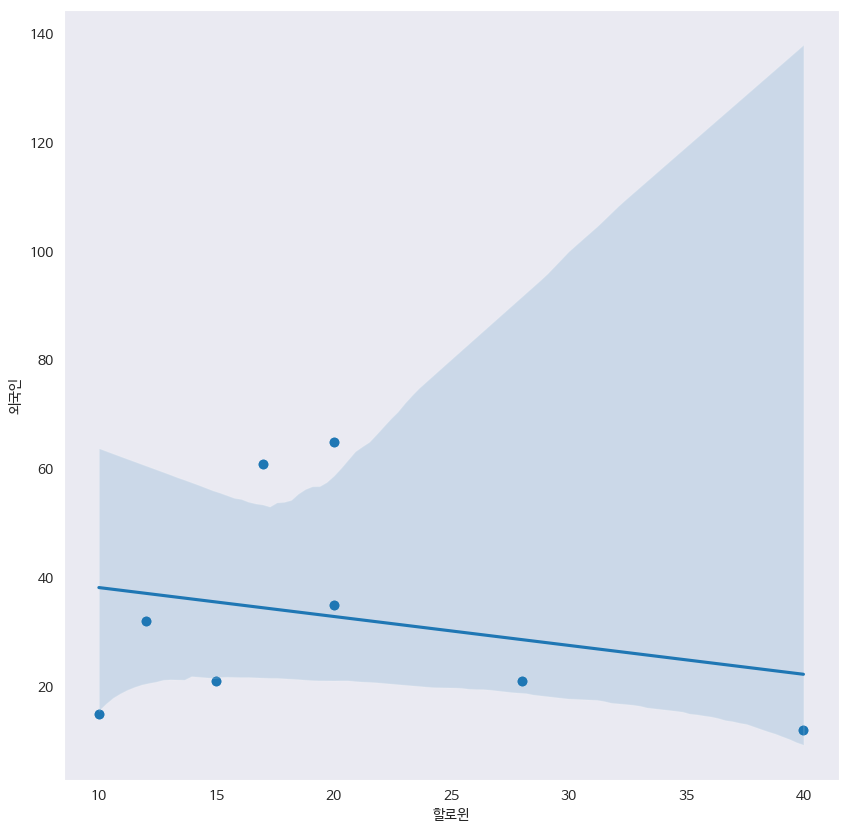

-0.5313681027966736 43.510204081632644
42.97883597883597


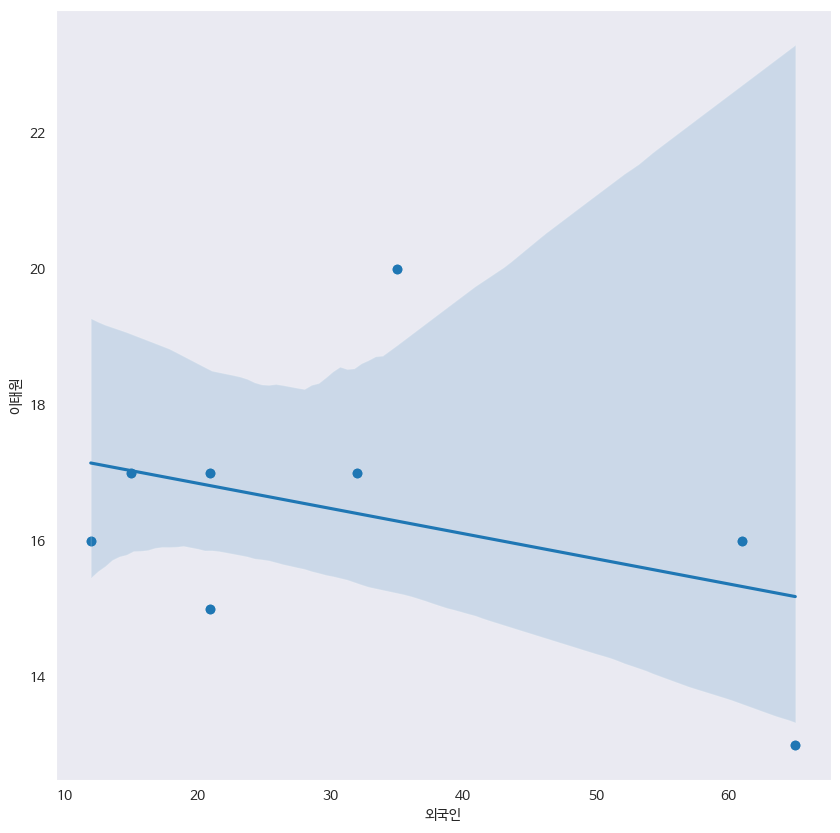

-0.037079043796894 17.58933868434828
17.552259640551387


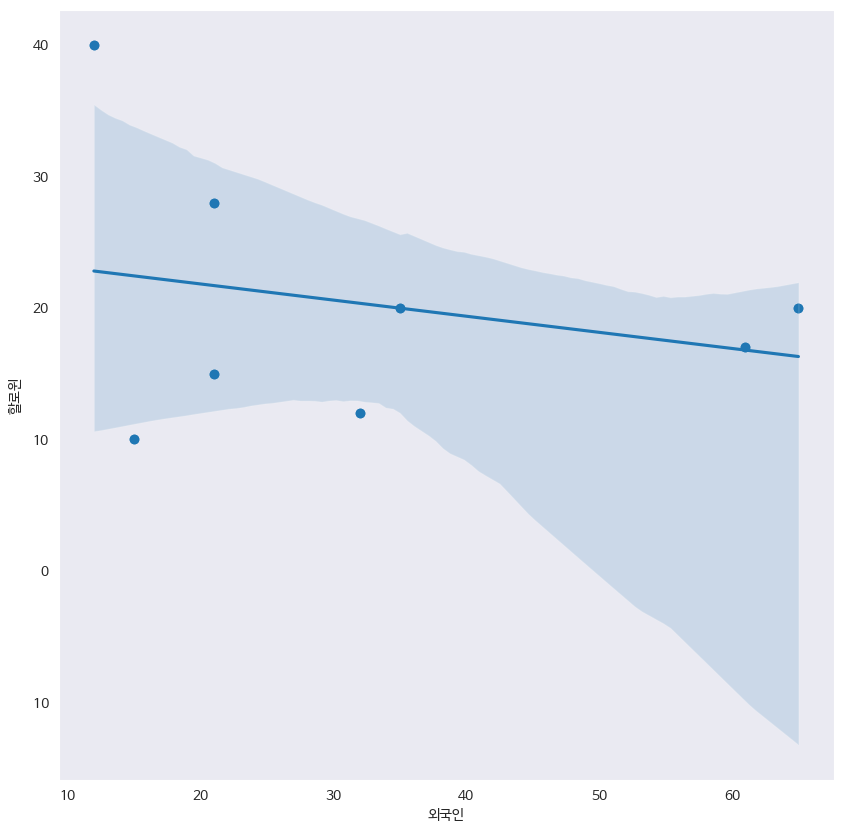

-0.12266620136101918 24.267318094573373
24.14465189321235


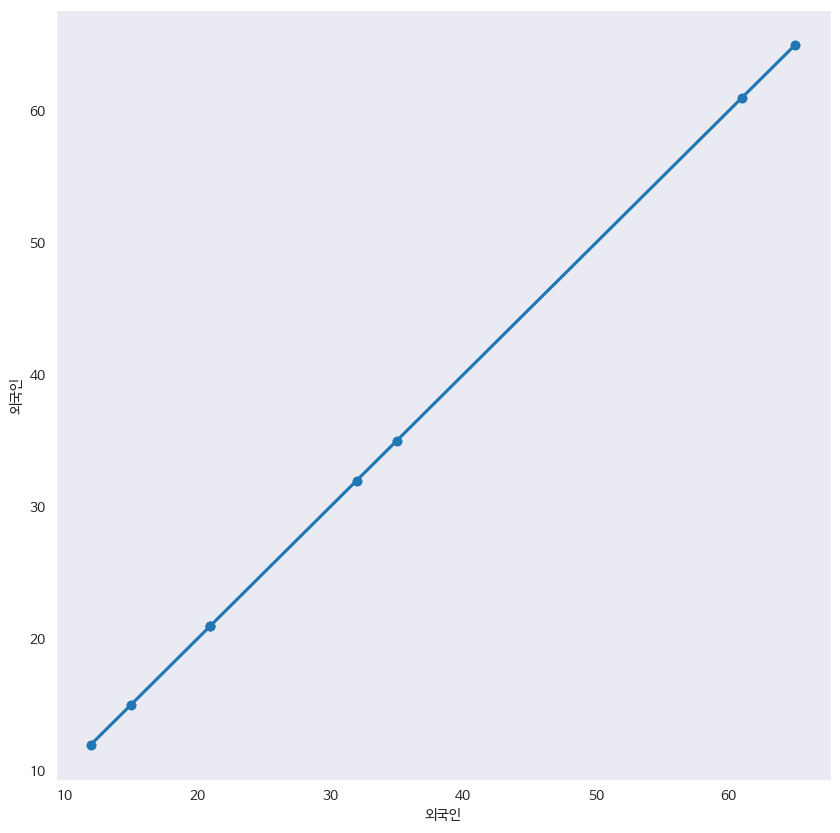

1.0000000000000004 0.0
1.0000000000000004


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# 한글폰트 사용 셋팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NanumBarunGothic.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import seaborn as sns
# 산점도 작성
for key1 in keyword_list:
        for key2 in keyword_list:
            plt.figure(figsize=(10, 10))         # 플롯 사이즈 지정
            plt.scatter(values_df[key1], values_df[key2]) # 산점도
            sns.regplot(x=key1, y=key2, data=values_df)
            plt.xlabel(key1)                  # x축 레이블 지정
            plt.ylabel(key2)                   # y축 레이블 지정
            plt.grid()                           # 플롯에 격자 보이기
            plt.show()                           # 플롯 보이기
            z = np.polyfit(values_df[key1], values_df[key2], 1)
            f = np.poly1d(z)
            print(z[0], z[1]) # 기울기, 절편
            print(f(1)) #f(x)

In [11]:
from statsmodels.formula.api import ols

dep_val = ''    # 종속변수
indep_val = ''   # 독립변수

for col in values_df.columns:
    if col == '이태원':
        dep_val += col + '~'
    else:
        indep_val += '+' + col

str = dep_val + indep_val[1:]
model = ols(str, data=values_df).fit()
model.summary()

D:\Users\user\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    이태원   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                 -0.173
Method:                 Least Squares   F-statistic:                    0.4826
Date:                Wed, 28 Dec 2022   Prob (F-statistic):              0.643
Time:                        11:28:25   Log-Likelihood:                -15.639
No. Observations:                   8   AIC:                             37.28
Df Residuals:                       5   BIC:                             37.52
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.3265      2.604      7.036      0.001      11.631      25.022
할로윈           -0.0304      0.087     -0.349      0.741      -0.254       0.193
외국인           -0.0408      0.042     -0.977      0.373      -0.148       0.067
==============================================================================
Omnibus:                        3.778   Durbin-Watson:                   1.148
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                1.002
Skew:                           0.855   Prob(JB):                        0.606
Kurtosis:                       3.289   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
regreRes = dict()

rsqu = model.rsquared
rsqu_double = rsqu * rsqu
fval = model.fvalue
f_pval = model.f_pvalue
dw = pd.read_html(model.summary().tables[2].as_html())[0][3][0]

regreRes['rsqu'] = rsqu
regreRes['rsqu_double'] = rsqu_double
regreRes['fval'] = fval
regreRes['f_pval'] = f_pval
regreRes['dw'] = dw

print(regreRes)

# print(model.params) # 비표준화계수 B
# bse = model.bse # 표준오차
# tval = model.tvalues    # t
# t_pval = model.pvalues  # 유의확률
#
# print(bse)

# print(model.params)   #coef

# print(model.bse)    # std err

# print(model.tvalues)  # t

# print(model.pvalues)  # P>|t|

# print(model.conf_int()) # [0.0225 0.975]


print(pd.read_html(model.summary().tables[2].as_html())[0])
print(pd.read_html(model.summary().tables[2].as_html())[0][3][0])

{'rsqu': 0.16180045844186497, 'rsqu_double': 0.026179388351997672, 'fval': 0.48258335402180286, 'f_pval': 0.6432333411674783, 'dw': 1.148}
                0      1                  2        3
0        Omnibus:  3.778     Durbin-Watson:    1.148
1  Prob(Omnibus):  0.151  Jarque-Bera (JB):    1.002
2           Skew:  0.855          Prob(JB):    0.606
3       Kurtosis:  3.289          Cond. No.  142.000
1.148


D:\Users\user\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
D:\Users\user\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
D:\Users\user\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [33]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def feature_engineering_XbyVIF(df, depNm):
    # df = df.drop([depNm], axis=1)
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(df.values, i)
                         for i in range(df.shape[1])]
    vif['Feature'] = df.columns
    return vif
vif = feature_engineering_XbyVIF(values_df, '이태원')
print(vif)

   VIF_Factor Feature
0    8.530543     이태원
1    5.539615     할로윈
2    3.404966     외국인
